### Google Colab Stuff

Todo: Program and test it

In [1]:
colab = False
if colab:
    from google.colab import drive
    drive.mount('/content/drive')   

In [2]:
try:
    import talib
except:
    !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
    !tar -xzvf ta-lib-0.4.0-src.tar.gz
    %cd ta-lib
    !./configure --prefix=/usr
    !make
    !make install
    !pip install Ta-Lib

    import talib

In [3]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [4]:
import os
import sys
import pandas as pd
import numpy as np
import json
import copy
import pickle
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from os import listdir
from os.path import isfile, join
from tqdm import tqdm
from datetime import datetime

### Add custom import paths for DataStreamCreator and IndicatorCalculator

In [5]:
# Get the current directory
current_dir = os.getcwd()
current_dir_splitted = current_dir.split(os.sep)
current_dir_splitted

['', 'home', 'jovyan', 'CryptoCrystalBall', 'JupyterDocker', 'notebooks']

In [6]:
# Create the import directories for the DataStreamCreator and the IndicatorCalculator
dsc_dir = os.path.join(os.sep, *current_dir_splitted[:-2], 'DataStreamCreator')
print(f"dsc_dir: {dsc_dir}")

ind_dir = os.path.join(os.sep, *current_dir_splitted[:-2], 'IndicatorCalculator')
print(f"ind_dir: {ind_dir}")

# Add them to the import paths
sys.path.insert(0, dsc_dir)
sys.path.insert(0, ind_dir)

dsc_dir: /home/jovyan/CryptoCrystalBall/DataStreamCreator
ind_dir: /home/jovyan/CryptoCrystalBall/IndicatorCalculator


In [7]:
# Import the actual classes
from IndicatorCalculator import IndicatorCalculator
import DataStreamCreator

In [8]:
# import tensorflow as tf

In [9]:
# from tensorflow.keras.layers import Input, Dense, ReLU, Add, Flatten, Concatenate, LayerNormalization, UpSampling2D, Activation, LSTM, Multiply, Dropout, Reshape, Permute, BatchNormalization, MaxPooling1D, AveragePooling1D, MaxPooling3D, AveragePooling2D, LayerNormalization, MaxPooling2D
# from tensorflow.keras.layers import Conv1D, Conv2D
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam

# Define all the parameters and variables

In [10]:
# Define the data path
DATA_PATH = os.path.join(os.sep, *current_dir_splitted[:-2], 'DemoData')
print(f"DATA_PATH: {DATA_PATH}")

DATA_PATH: /home/jovyan/CryptoCrystalBall/DemoData


In [11]:
# Define the chart image save path
IMG_SAVE_PATH = os.path.join(os.sep, *current_dir_splitted[:-2], 'Documentation', 'Images')
print(f"IMG_SAVE_PATH: {IMG_SAVE_PATH}")

IMG_SAVE_PATH: /home/jovyan/CryptoCrystalBall/Documentation/Images


In [12]:
# Define a global random seed
RANDOM_SEED = 11

In [13]:
# Set the seed
np.random.seed(RANDOM_SEED)

In [14]:
# Load the example OHLCV file
EXAMPLE_FILE_PATH = os.path.join(DATA_PATH, "BTC-USDT.csv")
EXAMPLE_FILE_PATH

'/home/jovyan/CryptoCrystalBall/DemoData/BTC-USDT.csv'

# Demonstration of YDataGenerator

The `YDataGenerator` class is used to generate future information for training out of a time series table of tick and indicator data.
This can for example be the assets relative price or gain in 24 hours, the direction of movement, or trade entry and exit signals.

IMPORTANT: This class can of course not look into the future, so if you want to output the price in 24 hours, this can only be done until
table index `len(timestamp rows) - 24`, otherwise it would really have to look into the future!

The purpose of this class is to generate machine-learning target data (y-values) according to the X-Blocks generated by the `XBlockGenerator`.
The X-Block contains data from the past, which is known in a live application, while the Y data is unknown in the live application, and therefore has to be predicted.
Here, it can be generated for training purposes using historical data.

As a price basis for calculating the y data, the `open` column of the input table `tick_DF` is used.

There are 4 different types of y data available, which are shown each on its own in the following section.

# Todo: More fancy doku

The y data generator can be structure into 4 sections, namely the 4 different types of signals that can be generated.

---
### Y_DATA_TYPE_DIRECTION_FLOAT

This data type generates a direction signal of price movement and its derivation. It takes the following parameters:
- `direction_ma_timespan`: Default 200, this parameter describes how fast the direction information follows price changes
- `derivation_ma_timespan`: Default 100, this parameter describes how fast the derivation information direction changes
- `direction_derivation_shift_span`: Default 0, this parameter sets a shifting of the direction and derivation information

The output of this data type is the direction of price movement and its derivation: `np.array [direction, directionDerivation]`

---
### Y_DATA_TYPE_DIRECTION_CATEGORICAL

This data type generates a direction signal of price movement and its derivation. It takes the following parameters:
- `direction_ma_timespan`: Default 200, this parameter describes how fast the direction information follows price changes
- `derivation_ma_timespan`: Default 100, this parameter describes how fast the derivation information direction changes
- `direction_derivation_shift_span`: Default 0, this parameter sets a shifting of the direction and derivation information
- `fall_threshold`: Default -0.2, this parameter set a limit for the direction value from which it shall be considered rising. The derivation of the direction has also to be over 0 to assume rising.
- `rise_threshold`: Default 0.1, this parameter set a limit for the direction value from which it shall be considered falling

The output of this data type is the integer category of the price movement based on its direction info (from the previous Y_DATA_TYPE_DIRECTION_FLOAT): `np.array [integerCategory]`

---
### Y_DATA_TYPE_TRADE_SIGNALS

This is the most sophisticated data generator based on the direction of price movement and its derivation. It uses three entry and two exit thresholds to generate trade signals whether one should enter (-> buy) or exit (-> sell). As the future is known in the train data generation step, very precise entry and exit signals can be generated. These signals can then be trained into a machine learning network.

As these parameters are rather sensitve and depend on the type of tick data (crypto, stock, long/short-term, ...), there will be a notebook for finding an optimum of them based on a training data set. (*Todo: Add the finder notebook*)

It takes the following parameters:
- `direction_ma_timespan`: Default 200, this parameter describes how fast the direction information follows price changes
- `derivation_ma_timespan`: Default 100, this parameter describes how fast the derivation information direction changes
- `direction_derivation_shift_span`: Default 0, this parameter sets a shifting of the direction and derivation information
- `future_direction_shift_timespan`: Default 24, this parameter determines from which future timestep the information is used to generate signals. (-> Look if a trade would be profitable)
- `entr_thr1`, `entr_thr2`, `entr_thr3`: Thresholds for generating entry signals based on this equation: `(direction >= entr_thr1) & (_direction_futureshifted >= entr_thr2) & (directionDerivation >= entr_thr3)`
- `exit_thr1`, `exit_thr2`: Thresholds for generating exit signals based on this equation: `(direction <= exit_thr1) & (_direction_futureshifted <= exit_thr2)`

The output of this data type is the one-hot-encoded category of the price movement: `np.array [entry, exit, neutral]`

---

In [15]:
# Load the OHLCV table
tickdata = pd.read_csv(EXAMPLE_FILE_PATH)
tickdata.set_index("startsAt", inplace = True) # Todo: Take care of the index name
tickdata.sort_index()
 
tickdata

,open,high,low,close,volume,quoteVolume
startsAt,,,,,,
1449928800,420.000000,420.000000,420.000000,420.000000,0.000304,0.127596
1449932400,420.000000,420.000000,420.000000,420.000000,0.000000,0.000000
1449936000,420.000000,420.000000,420.000000,420.000000,0.000000,0.000000
1449939600,420.000000,420.000000,420.000000,420.000000,0.000000,0.000000
1449943200,420.000000,420.000000,420.000000,420.000000,0.000000,0.000000
...,...,...,...,...,...,...
1627761600,41312.243514,41819.689357,41174.024002,41504.090831,6.954679,288855.157694
1627765200,41532.010689,41974.904927,41532.010689,41960.070000,7.271290,303437.038256
1627768800,41961.294435,41977.030664,41645.385796,41870.548474,6.137356,256691.373423


---
### Visualization of y for Y_DATA_TYPE_DIRECTION_FLOAT

In [16]:
# Get the template parameter dict for this y type
Y_PARAM_DICT_TEMPLATE = copy.deepcopy(DataStreamCreator.YDataGenerator.PARAM_DICT_TEMPLATE_Y_DATA_TYPE_DIRECTION_FLOAT)
Y_PARAM_DICT_TEMPLATE

{'dataType': 0,
 'direction_ma_timespan': 200,
 'derivation_ma_timespan': 100,
 'direction_derivation_shift_span': 0}

In [17]:
yDataGenerator = DataStreamCreator.YDataGenerator(tick_DF=tickdata,
                                                    generator_batch_size=10000,
                                                    lookback_cnt=100,
                                                    y_type_dict=Y_PARAM_DICT_TEMPLATE
                                                    )
yData = next(yDataGenerator)
print(f"yData.shape: {yData.shape}")

yData.shape: (10000, 2)


In [18]:
yData[:5]

array([[ 0.        , -0.00015946],
       [ 0.        , -0.00031638],
       [ 0.        , -0.00047575],
       [ 0.        , -0.00063765],
       [ 0.        , -0.00080215]])

In [19]:
y_dir = yData[:,0]
y_dir_derivation = yData[:,1]

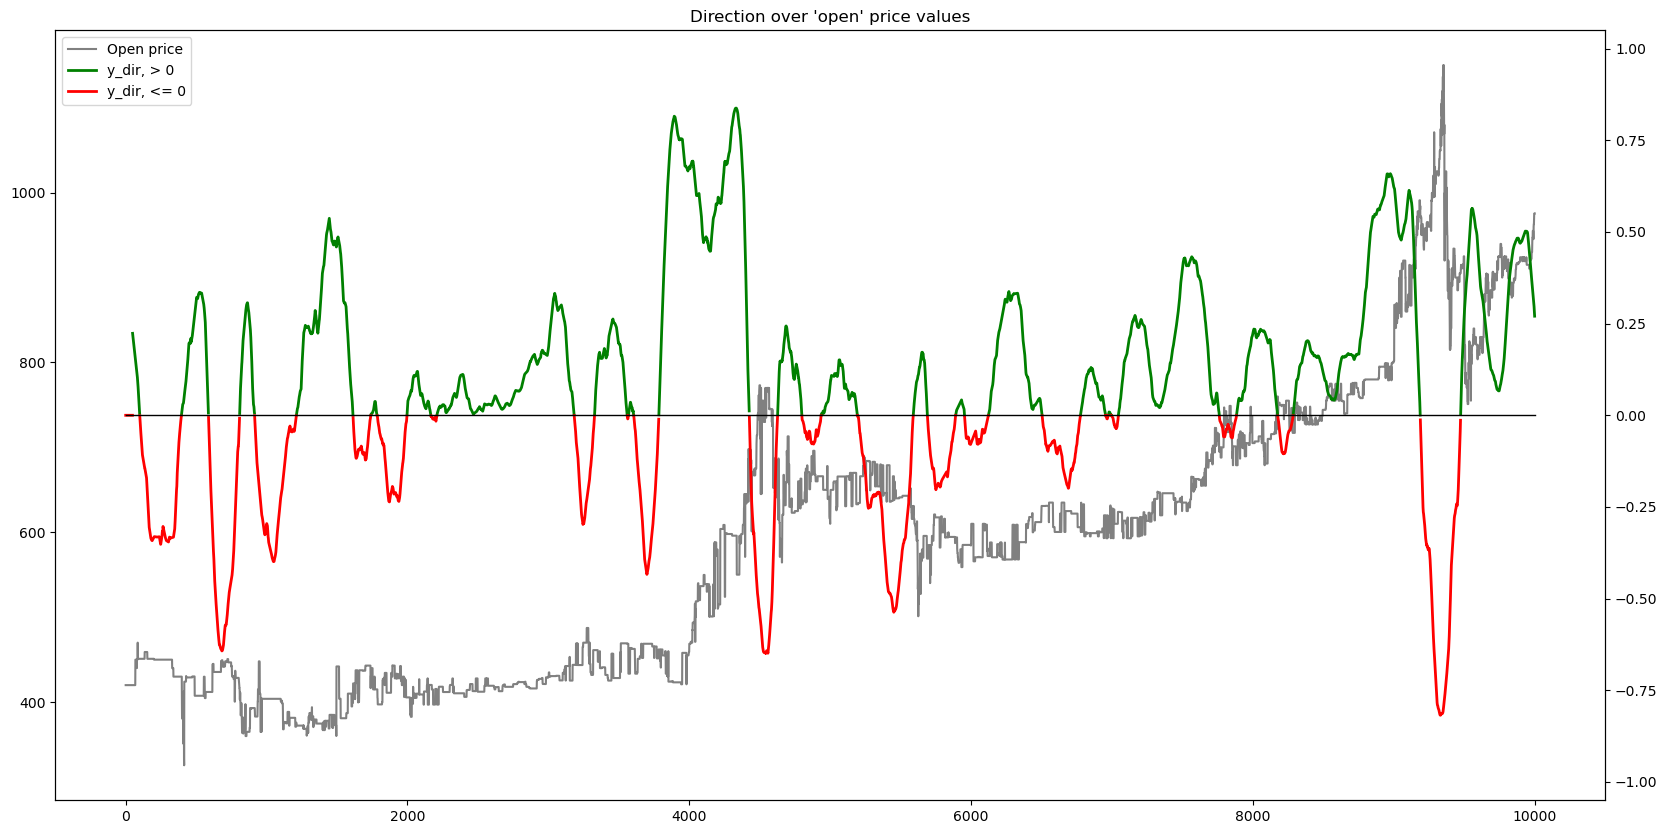

In [20]:
# Plot the direction information
chart_name="Direction over 'open' price values"
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title(chart_name)

x_len = 10000

ax1.plot(tickdata.loc[:,'open'].values[:x_len], color="gray", label="Open price")

ax2 = ax1.twinx()
ax2.set_ylim(-1.05,1.05)

# Split the direction data into rise and fall for plotting
y_dir_rise = np.array(y_dir)
y_dir_fall = np.array(y_dir)

y_dir_rise[y_dir_rise <= 0] = np.nan
y_dir_fall[y_dir_fall > 0] = np.nan

ax2.plot(y_dir_rise, color="green", linewidth=2, label="y_dir, > 0")
ax2.plot(y_dir_fall, color="red", linewidth=2, label="y_dir, <= 0")


# Plot a zero line
ax2.plot([0,x_len], [0,0], color="black", linewidth=1)

# Show a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="upper left")

# Save the figure
fig_name = chart_name.replace(" ", "_").replace("'", "") + ".svg"
plt.savefig(os.path.join(IMG_SAVE_PATH, fig_name), bbox_inches="tight")

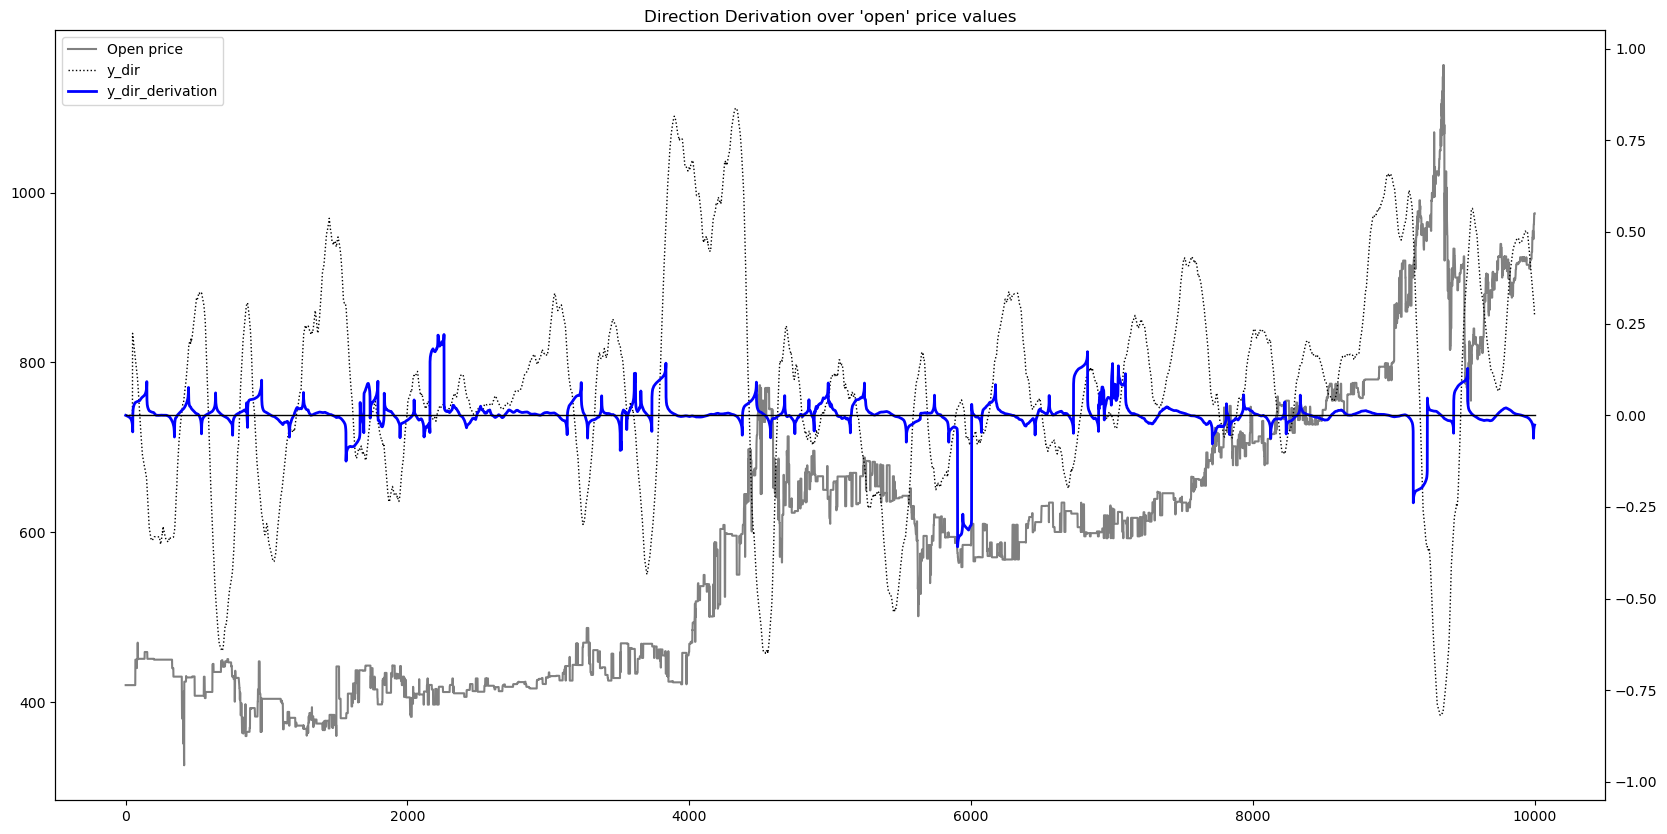

In [21]:
# Plot the direction information
chart_name="Direction Derivation over 'open' price values"
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title(chart_name)

x_len = 10000

ax1.plot(tickdata.loc[:,'open'].values[:x_len], color="gray", label="Open price")

ax2 = ax1.twinx()
ax2.set_ylim(-1.05,1.05)

ax2.plot(y_dir, color="black", linewidth=1, linestyle=":", label="y_dir")
ax2.plot(y_dir_derivation, color="blue", linewidth=2, label="y_dir_derivation")

# Plot a zero line
ax2.plot([0,x_len], [0,0], color="black", linewidth=1)

# Show a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="upper left")

# Save the figure
fig_name = chart_name.replace(" ", "_").replace("'", "") + ".svg"
plt.savefig(os.path.join(IMG_SAVE_PATH, fig_name), bbox_inches="tight")

---
### Now lets try to shift the direction and derivation info for 7 days (= 168 hours)

This can be used to get y data from more far into the future

In [22]:
# Get the template parameter dict for this y type
Y_PARAM_DICT = copy.deepcopy(DataStreamCreator.YDataGenerator.PARAM_DICT_TEMPLATE_Y_DATA_TYPE_DIRECTION_FLOAT)
Y_PARAM_DICT['direction_derivation_shift_span'] = 7*24
Y_PARAM_DICT

{'dataType': 0,
 'direction_ma_timespan': 200,
 'derivation_ma_timespan': 100,
 'direction_derivation_shift_span': 168}

In [23]:
yDataGeneratorShifted = DataStreamCreator.YDataGenerator(tick_DF=tickdata,
                                                    generator_batch_size=10000,
                                                    lookback_cnt=100,
                                                    y_type_dict=Y_PARAM_DICT
                                                    )
yDataShifted = next(yDataGeneratorShifted)
print(f"yDataShifted.shape: {yDataShifted.shape}")

yDataShifted.shape: (10000, 2)


In [24]:
y_dir_shifted = yDataShifted[:,0]
y_dir_derivation_shifted = yDataShifted[:,1]

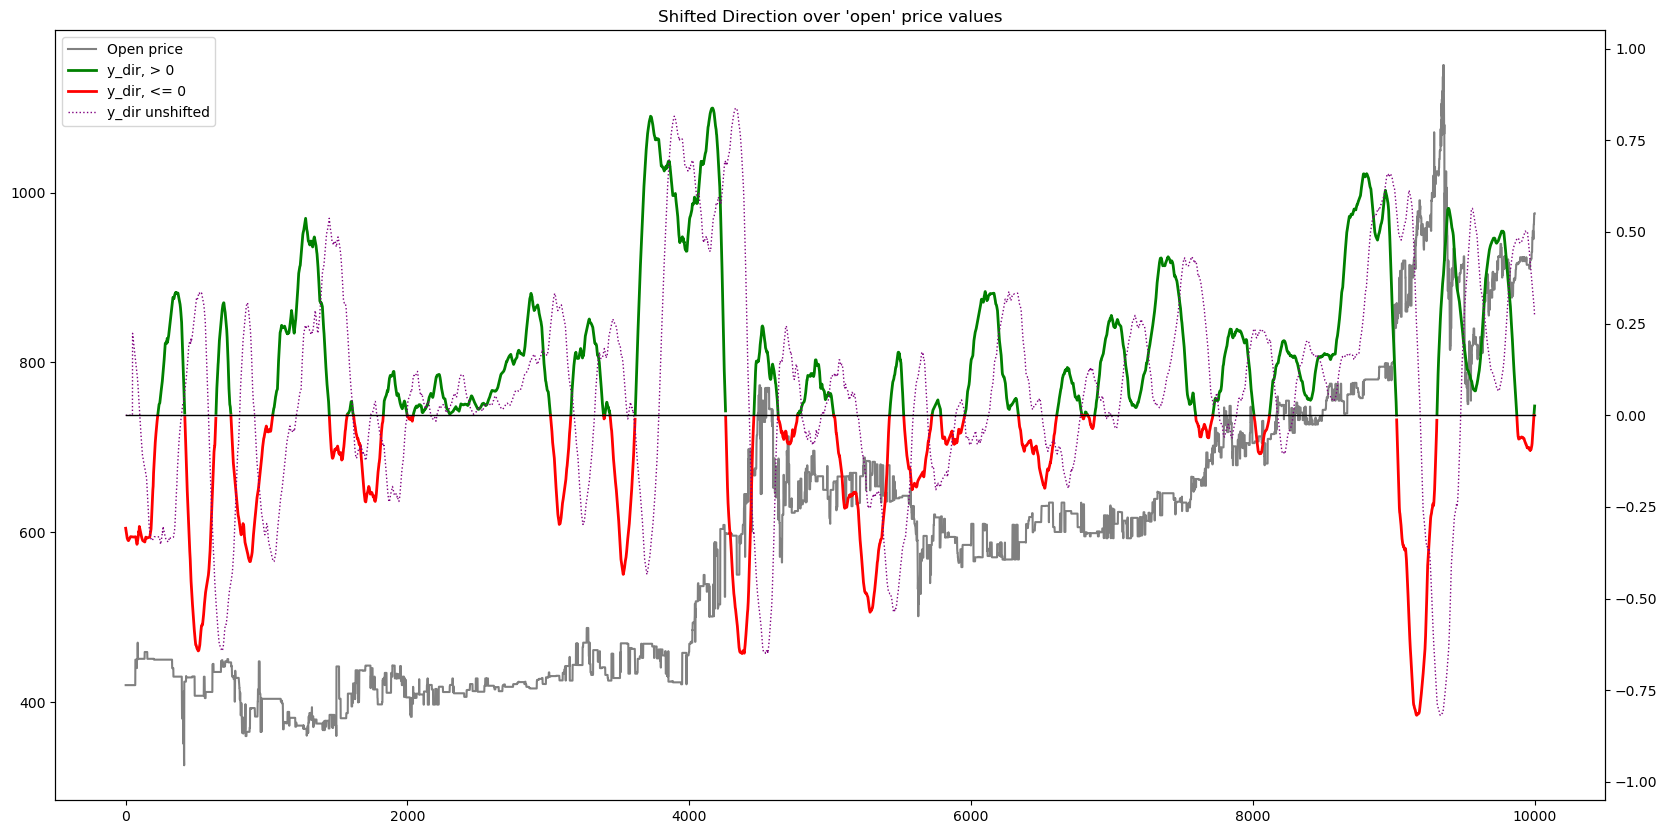

In [25]:
# Plot the shifted direction information
chart_name="Shifted Direction over 'open' price values"
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title(chart_name)

x_len = 10000

ax1.plot(tickdata.loc[:,'open'].values[:x_len], color="gray", label="Open price")

ax2 = ax1.twinx()
ax2.set_ylim(-1.05,1.05)

# Split the direction data into rise and fall for plotting
y_dir_rise = np.array(y_dir_shifted)
y_dir_fall = np.array(y_dir_shifted)

y_dir_rise[y_dir_rise <= 0] = np.nan
y_dir_fall[y_dir_fall > 0] = np.nan

ax2.plot(y_dir_rise, color="green", linewidth=2, label="y_dir, > 0")
ax2.plot(y_dir_fall, color="red", linewidth=2, label="y_dir, <= 0")

ax2.plot(y_dir, color="purple", linewidth=1, linestyle=":", label="y_dir unshifted")

# Plot a zero line
ax2.plot([0,x_len], [0,0], color="black", linewidth=1)

# Show a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="upper left")

---
### Visualization of y for Y_DATA_TYPE_DIRECTION_CATEGORICAL

In [26]:
# Get the template parameter dict for this y type
Y_PARAM_DICT = copy.deepcopy(DataStreamCreator.YDataGenerator.PARAM_DICT_TEMPLATE_Y_DATA_TYPE_DIRECTION_CATEGORICAL)
Y_PARAM_DICT

{'dataType': 1,
 'direction_ma_timespan': 200,
 'derivation_ma_timespan': 100,
 'direction_derivation_shift_span': 0,
 'fall_threshold': -0.2,
 'rise_threshold': 0.1}

In [27]:
yDataGenerator = DataStreamCreator.YDataGenerator(tick_DF=tickdata,
                                                    generator_batch_size=10000,
                                                    lookback_cnt=100,
                                                    y_type_dict=Y_PARAM_DICT
                                                    )
yCategory = next(yDataGenerator)
print(f"yCategory.shape: {yCategory.shape}")

yCategory.shape: (10000,)


In [28]:
yCategory[:400]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

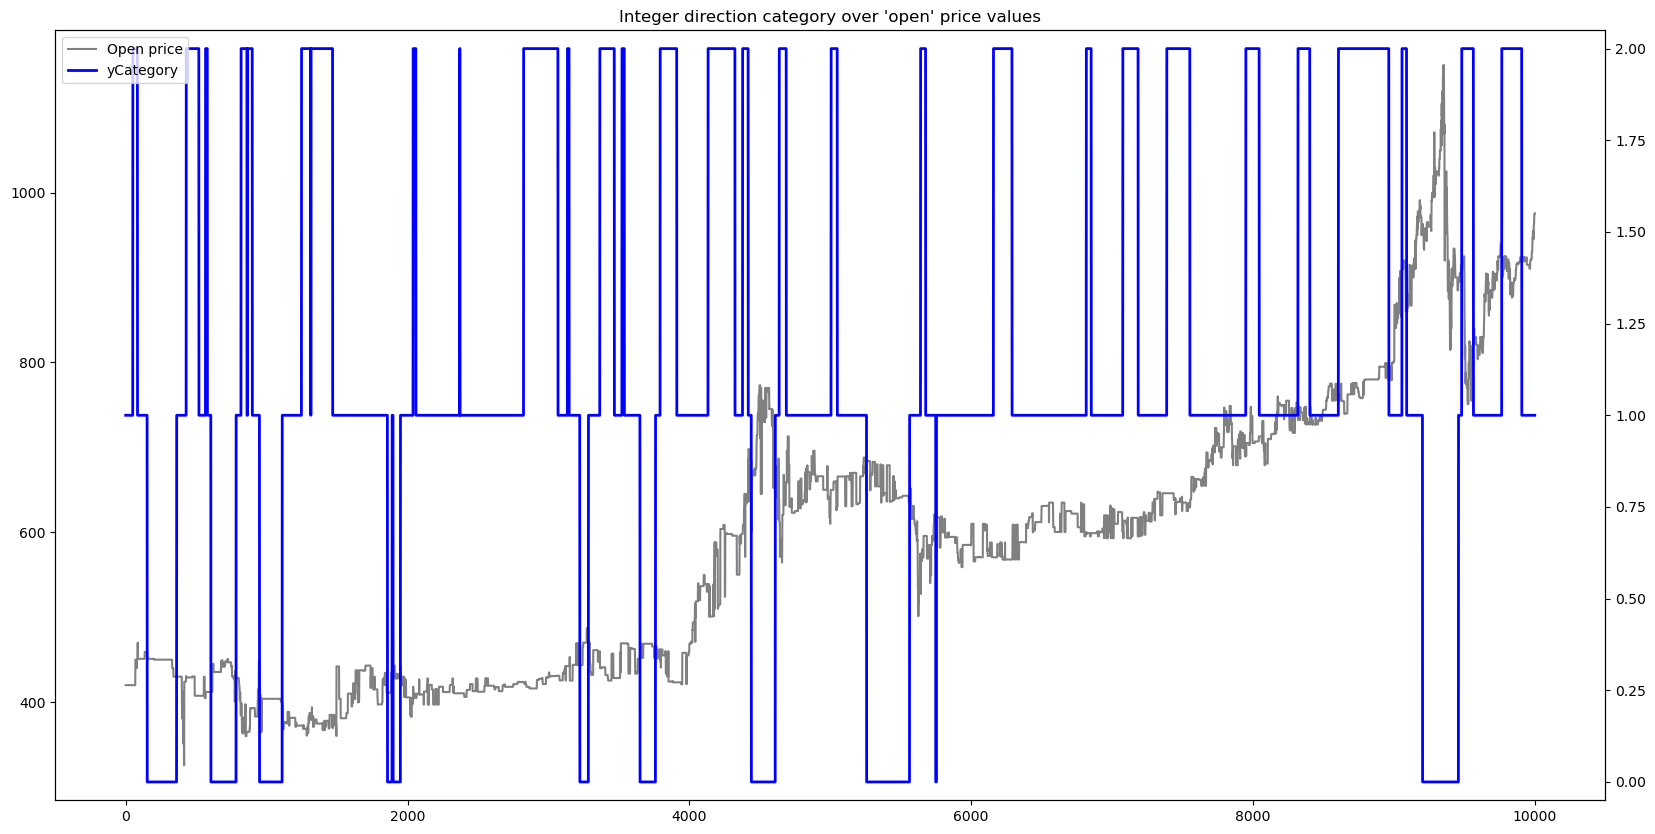

In [29]:
# Plot the integer category information
chart_name="Integer direction category over 'open' price values"
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title(chart_name)

x_len = 10000

ax1.plot(tickdata.loc[:,'open'].values[:x_len], color="gray", label="Open price")

ax2 = ax1.twinx()
ax2.set_ylim(-0.05,2.05)

ax2.plot(yCategory, color="blue", linewidth=2, label="yCategory")

# Show a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="upper left")

In [30]:
# Split it into seperate category arrays
yCategoryFall = np.zeros(yCategory.shape)
yCategoryNeutral = np.zeros(yCategory.shape)
yCategoryRise = np.zeros(yCategory.shape)

yCategoryFall[0 == yCategory] = 1
yCategoryNeutral[1 == yCategory] = 1
yCategoryRise[2 == yCategory] = 1

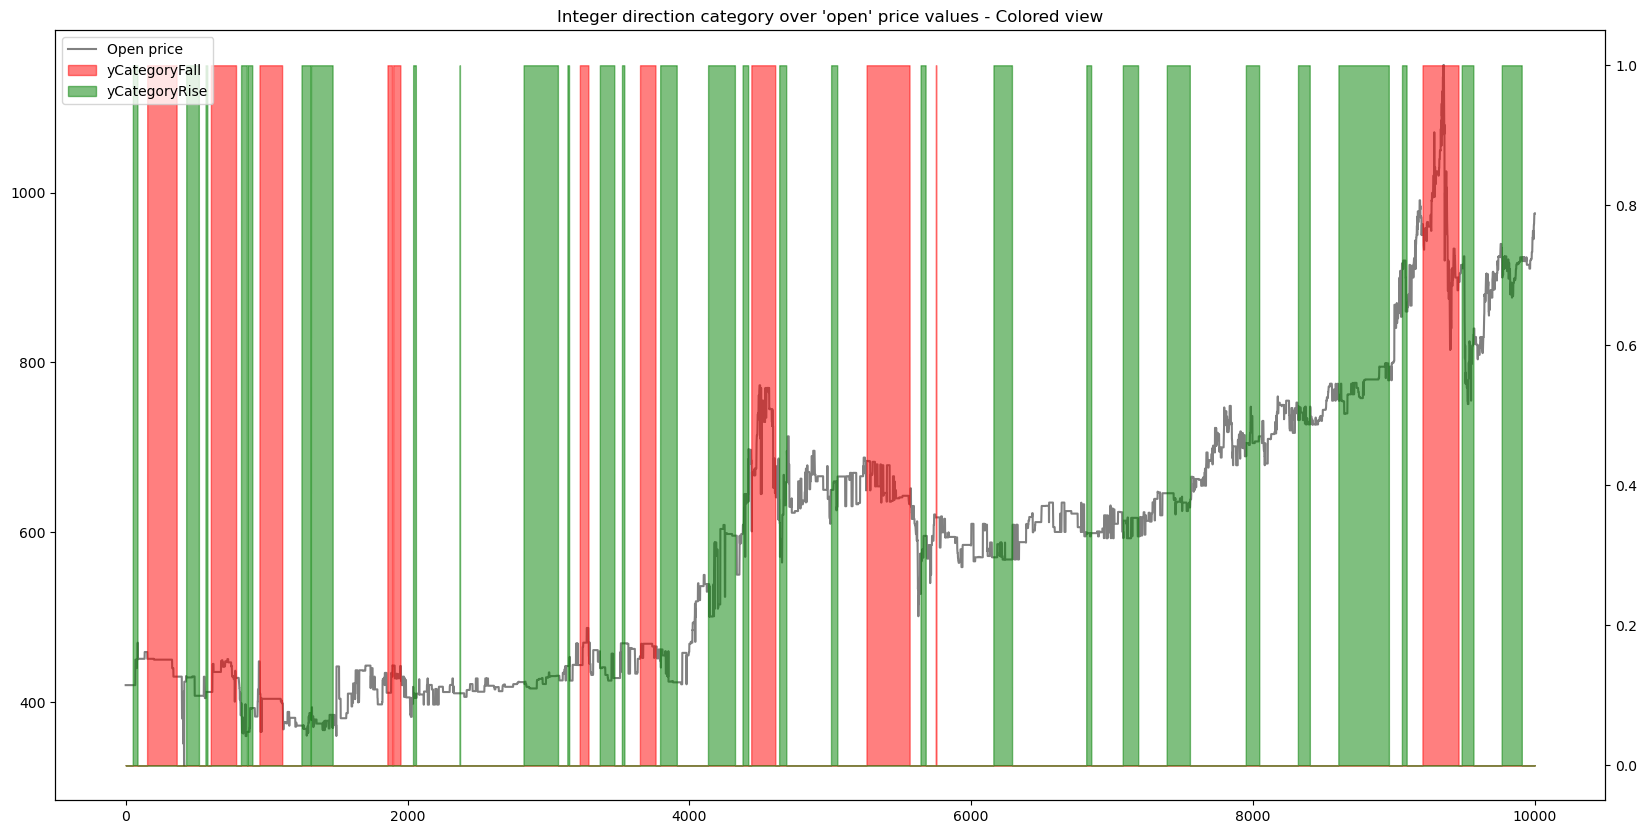

In [31]:
# Plot a nicer category information
chart_name="Integer direction category over 'open' price values - Colored view"
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title(chart_name)

x_len = 10000

ax1.plot(tickdata.loc[:,'open'].values[:x_len], color="gray", label="Open price")

ax2 = ax1.twinx()
ax2.set_ylim(-0.05,1.05)

# ax2.plot(yCategoryFall, color="red", linewidth=2, label="yCategoryFall")
# ax2.plot(yCategoryNeutral, color="blue", linewidth=1, label="yCategoryNeutral")
# ax2.plot(yCategoryRise, color="green", linewidth=2, label="yCategoryRise")

ax2.fill_between(range(x_len), yCategoryFall , alpha=0.5, color="red", label="yCategoryFall")
ax2.fill_between(range(x_len), yCategoryRise , alpha=0.5, color="green", label="yCategoryRise")

# Show a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="upper left")

# Save the figure
fig_name = chart_name.replace(" ", "_").replace("'", "") + ".svg"
plt.savefig(os.path.join(IMG_SAVE_PATH, fig_name), bbox_inches="tight")

---
### Visualization of y for Y_DATA_TYPE_TRADE_SIGNALS

In [32]:
# Get the template parameter dict for this y type
Y_PARAM_DICT = copy.deepcopy(DataStreamCreator.YDataGenerator.PARAM_DICT_TEMPLATE_Y_DATA_TYPE_TRADE_SIGNALS)

# Entry and exit threshold have to be adapted to the type of tick data (crypto, stock, long/short-term, ...)
Y_PARAM_DICT['entr_thr1'] = 0.5
Y_PARAM_DICT['entr_thr2'] = 0.4

Y_PARAM_DICT

{'dataType': 2,
 'direction_ma_timespan': 200,
 'derivation_ma_timespan': 100,
 'direction_derivation_shift_span': 0,
 'future_direction_shift_timespan': 24,
 'entr_thr1': 0.5,
 'entr_thr2': 0.4,
 'entr_thr3': 0.0,
 'exit_thr1': -0.5,
 'exit_thr2': 0.1}

In [33]:
yDataGenerator = DataStreamCreator.YDataGenerator(tick_DF=tickdata,
                                                    generator_batch_size=10000,
                                                    lookback_cnt=100,
                                                    y_type_dict=Y_PARAM_DICT
                                                    )
ySignals = next(yDataGenerator)
print(f"ySignals.shape: {ySignals.shape}")

ySignals.shape: (10000, 3)


In [34]:
ySignals[:5]

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [35]:
entrySignals = ySignals[:,0]
exitSignals = ySignals[:,1]
neutralSignals = ySignals[:,2]

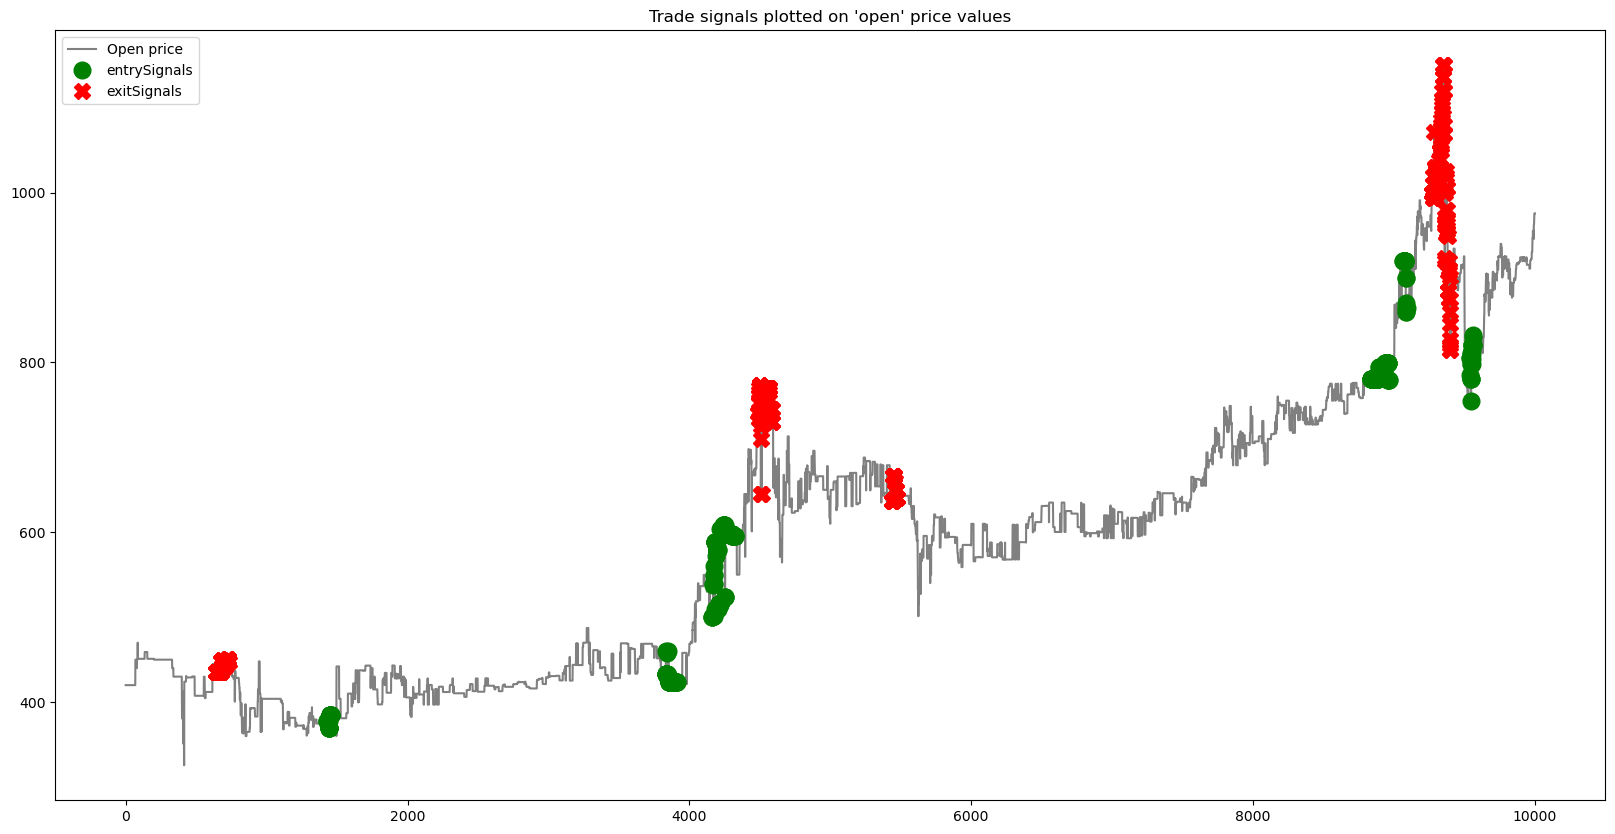

In [37]:
# Plot the entry and exit signals
chart_name="Trade signals plotted on 'open' price values"
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title(chart_name)

# Multiply the signals with the price to draw them directly on the price graph
openPriceValues = tickdata.loc[:,'open'].values[:x_len]
entrySignalsChart = entrySignals * openPriceValues
exitSignalsChart = exitSignals * openPriceValues

entrySignalsChart[0 == entrySignalsChart] = np.nan
exitSignalsChart[0 == exitSignalsChart] = np.nan

x_len = 10000

ax1.plot(tickdata.loc[:,'open'].values[:x_len], color="gray", label="Open price")

ax1.plot(entrySignalsChart, color="green", linewidth=0, marker="o", markersize="12", label="entrySignals")
ax1.plot(exitSignalsChart, color="red", linewidth=0, marker="X", markersize="12", label="exitSignals")

# Show a legend
ax1.legend(loc="upper left")

# Save the figure
fig_name = chart_name.replace(" ", "_").replace("'", "") + ".svg"
plt.savefig(os.path.join(IMG_SAVE_PATH, fig_name), bbox_inches="tight")